In [152]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [153]:
df = pd.read_csv('asset_1.csv')

print(df.head())


   serial_num         price     alpha
0           0  18105.300781  0.000000
1           1  18398.960605 -0.630291
2           2  18204.939538 -0.123420
3           3  18339.357782 -0.240239
4           4  18578.084798 -0.612625


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   serial_num  6000 non-null   int64  
 1   price       6000 non-null   float64
 2   alpha       6000 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 140.8 KB


In [155]:
df.describe()

,serial_num,price,alpha
count,6000.000000,6000.000000,6000.000000
mean,2999.500000,14242.914766,-0.001921
std,1732.195139,4123.474458,0.555028
min,0.000000,6956.385732,-2.000000
25%,1499.750000,10590.938148,-0.367825
50%,2999.500000,14105.556844,-0.001787
75%,4499.250000,17867.634516,0.369683
max,5999.000000,25608.051858,2.000000


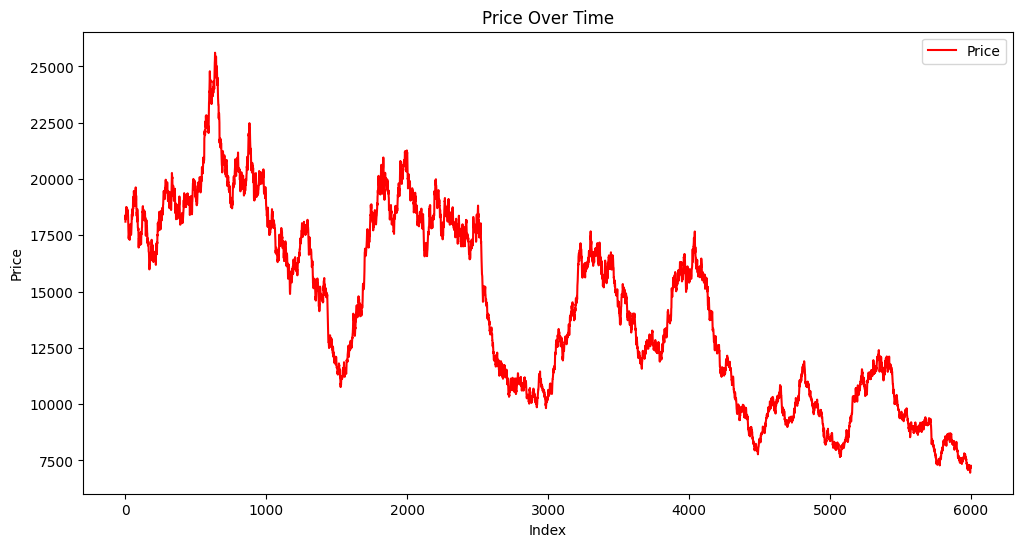

In [156]:
# Plotting the price
plt.figure(figsize=(12, 6))
plt.plot(df['serial_num'], df['price'], color='red', label='Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.legend()
plt.show()

#### since there are lots of fluctuating values of the alphas, creating an interactive plot using plotly

In [157]:
import plotly.express as px

In [158]:
# Plot for alpha values
fig = px.line(df, x='serial_num', y='alpha', title='Alpha Over Time', labels={'serial_num': 'Index', 'alpha': 'Alpha'})

fig.show()

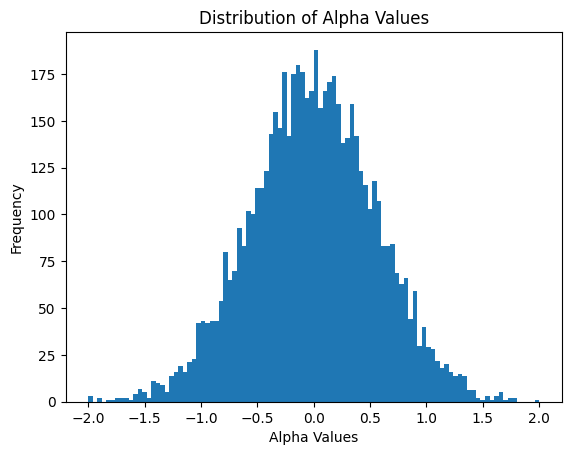

In [159]:
# Histogram of alpha values
plt.hist(df['alpha'], bins=100)
plt.xlabel('Alpha Values')
plt.ylabel('Frequency')
plt.title('Distribution of Alpha Values')
plt.show()

#### Task 1

**As told in the PS :**
* Let’s say the build threshold is 0.6 and liquidate threshold is 0.2. When the alpha goes from 0.5 to 0.8, you build a position of 1 unit, buying 1 stock. When the alpha goes from 0.8 to 0.4, you do nothing. When the alpha goes from 0.4 to 0.1, you liquidate your position, now holding 0 units. When the alpha goes from 0.1 to -0.5, you do nothing. When the alpha goes from -0.5 to -1.2, you build a negative position, shorting the stock and holding -1 stocks. When the alpha goes from -1.2 to -1, you do nothing. When the alpha goes from -1 to 0, you liquidate your position, holding 0 stocks.

In [160]:
def apply_static_strategy(df, build_threshold=0.6, liquidate_threshold=0.2):
    positions = []
    current_position = 0  # Starting initially with no position

    for index, row in df.iterrows():
        alpha = row['alpha']

        if current_position == 0:  # No position

            if alpha >= build_threshold:
                current_position = 1  # Buying
            elif alpha <= -build_threshold:
                current_position = -1  # Selling

        elif current_position == 1:  # Holding a long position
            if alpha <= liquidate_threshold:
                current_position = 0  # Liquidating the position

        elif current_position == -1:  # Holding a short position
            if alpha >= -liquidate_threshold:
                current_position = 0  # Liquidating again
        
        positions.append(current_position)

    df['position'] = positions
    return df

In [161]:
df = apply_static_strategy(df)

In [162]:
df

,serial_num,price,alpha,position
0,0,18105.300781,0.000000,0
1,1,18398.960605,-0.630291,-1
2,2,18204.939538,-0.123420,0
3,3,18339.357782,-0.240239,0
4,4,18578.084798,-0.612625,-1
...,...,...,...,...
5995,5995,7035.576315,-0.318083,0
5996,5996,7232.249459,-0.199650,0
5997,5997,7224.645159,-0.076274,0
5998,5998,7167.188831,1.106138,1


#### Task 2

In [163]:
def backtest_strategy(df):
    
    df['next_price'] = df['price'].shift(-1)  # shifting the columns one above
    df.dropna(inplace=True) 

    df['returns'] = df['next_price'] - df['price']
    df['strategy_returns'] = df['position'] * df['returns']
    
    df['cumulative_pnl'] = df['strategy_returns'].cumsum()   # column of the cumulative sum...
    
    final_pnl = df['cumulative_pnl'].iloc[-1]  # the last element of the cumulative columns is the final pnl
     
    return df, final_pnl

In [164]:
df, final_pnl = backtest_strategy(df)

print(f"Final PnL: {final_pnl}")

Final PnL: 26250.881404344836


#### Task 3

In [165]:
def optimize_thresholds(df, build_range, liquidate_range):
    
    best_pnl = -np.inf
    best_thresholds = (None, None)
    
    for build_threshold in build_range:
        for liquidate_threshold in liquidate_range:
            df = apply_static_strategy(df, build_threshold, liquidate_threshold)
            df, pnl = backtest_strategy(df)
            if pnl > best_pnl:
                best_pnl = pnl
                best_thresholds = (build_threshold, liquidate_threshold)
    
    return best_thresholds, best_pnl

* The range of thresholds should typically lie within the range of the alpha values. 
* Coz, thresholds are used to trigger trading decisions based on the observed alpha values, \
and if the thresholds are outside the observed range of alpha values, \
they would never be reached, thus resulting in no trades being executed.

In [166]:
# Ranges for the grid search

# Going the highest possible range i.e. the range of alpha itself
build_range = np.linspace(-2.0, 2.0, 30)  
liquidate_range = np.linspace(-2.0, 2.0, 30) 

# Optimize the thresholds
best_thresholds, best_pnl = optimize_thresholds(df.copy(), build_range, liquidate_range)  # passing a copy to avoid changes on the main DataFrame

# Optimal thresholds and the corresponding PnL
print(f"Best Build Threshold: {best_thresholds[0]}")
print(f"Best Liquidate Threshold: {best_thresholds[1]}")
print(f"Best PnL: {best_pnl}")

Best Build Threshold: 0.2068965517241379
Best Liquidate Threshold: -1.1724137931034484
Best PnL: 30980.249854203452


In [167]:
df

,serial_num,price,alpha,position,next_price,returns,strategy_returns,cumulative_pnl
0,0,18105.300781,0.000000,0,18398.960605,293.659824,0.000000,0.000000
1,1,18398.960605,-0.630291,-1,18204.939538,-194.021067,194.021067,194.021067
2,2,18204.939538,-0.123420,0,18339.357782,134.418244,0.000000,194.021067
3,3,18339.357782,-0.240239,0,18578.084798,238.727016,0.000000,194.021067
4,4,18578.084798,-0.612625,-1,18710.626967,132.542168,-132.542168,61.478899
...,...,...,...,...,...,...,...,...
5994,5994,6956.385732,1.433824,1,7035.576315,79.190584,79.190584,26156.100174
5995,5995,7035.576315,-0.318083,0,7232.249459,196.673144,0.000000,26156.100174
5996,5996,7232.249459,-0.199650,0,7224.645159,-7.604300,-0.000000,26156.100174
5997,5997,7224.645159,-0.076274,0,7167.188831,-57.456328,-0.000000,26156.100174


#### Bonus
* Class based implementation of strategy and back testing engine

In [168]:
class TradingStrategy:
    def __init__(self, build_threshold=0.6, liquidate_threshold=0.2):
        self.build_threshold = build_threshold
        self.liquidate_threshold = liquidate_threshold
        self.positions = []
    
    def apply_strategy(self, df):
        positions = []
        current_position = 0  # Starting with no position

        for index, row in df.iterrows():
            alpha = row['alpha']

            if current_position == 0:  # No position
                if alpha >= self.build_threshold:
                    current_position = 1  # Buying
                elif alpha <= -self.build_threshold:
                    current_position = -1  # Selling

            elif current_position == 1:  # Holding a long position
                if alpha <= self.liquidate_threshold:
                    current_position = 0  # Liquidating
                    
            elif current_position == -1:  # Holding a short position
                if alpha >= -self.liquidate_threshold:
                    current_position = 0  # Again Liquidating
            
            positions.append(current_position)

        df['position'] = positions
        return df

In [169]:
class BacktestEngine:
    def __init__(self, strategy):
        self.strategy = strategy

    def backtest(self, df):
        df = self.strategy.apply_strategy(df)
        df['next_price'] = df['price'].shift(-1)
        df.dropna(inplace=True)  # Removing the last row with NaN value of next_price

        df['returns'] = df['next_price'] - df['price']
        df['strategy_returns'] = df['position'] * df['returns']
        
        # Cumulative PnL
        df['cumulative_pnl'] = df['strategy_returns'].cumsum()
        
        # Final PnL
        final_pnl = df['cumulative_pnl'].iloc[-1]
        
        return df, final_pnl

#### trying the bayesian optimization function to get the most optimal thresholds

In [171]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

In [172]:
def objective(params):
    build_threshold, liquidate_threshold = params
    strategy = TradingStrategy(build_threshold, liquidate_threshold)
    engine = BacktestEngine(strategy)
    _, final_pnl = engine.backtest(df)
    return -final_pnl  # I am minimize the negative PnL to maximize PnL

In [175]:
# Search space
space = [
    Real(-2.0, 2.0, name='build_threshold'),
    Real(-2.0, 2.0, name='liquidate_threshold')
]

# Bayesian Optimization
res = gp_minimize(objective, space, n_calls=100, random_state=786)

# Get the best parameters
best_build_threshold = res.x[0]
best_liquidate_threshold = res.x[1]
best_pnl = -res.fun

In [176]:
print(f"Best Build Threshold: {best_build_threshold}")
print(f"Best Liquidate Threshold: {best_liquidate_threshold}")
print(f"Best PnL: {best_pnl}")

Best Build Threshold: 0.1730573057437601
Best Liquidate Threshold: 0.1664275711340344
Best PnL: 33553.140927631015


#### better pnl than the grid search algorithm

In [177]:
# Example usage
strategy = TradingStrategy(build_threshold=0.1730573057437601, liquidate_threshold=0.1664275711340344)
engine = BacktestEngine(strategy)
df, final_pnl = engine.backtest(df.copy())

print(f"Final PnL: {final_pnl}")

Final PnL: 33800.039154134705
